<a href="https://colab.research.google.com/github/rafaelhab/unsupervisedlearning/blob/master/CLUSTERING_7LABELED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

De los datasets de UCI Machine Learning, tomé Activity Recognition from Single Chest-Mounted Accelerometer Data Set <br>

La URL es: https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer


Source:<br>

Uncalibrated Accelerometer Data are collected from 15 participantes performing 7 activities. The dataset provides challenges for identification and authentication of people using motion patterns.


Data Set Information:<br>

--- The dataset collects data from a wearable accelerometer mounted on the chest <br>
--- Sampling frequency of the accelerometer: 52 Hz <br>
--- Accelerometer Data are Uncalibrated <br>
--- Number of Participants: 15 <br>
--- Number of Activities: 7 <br>
--- Data Format: CSV<br>

Attribute Information:<br>

--- Data are separated by participant <br>
--- Each file contains the following information <br>
---- sequential number, x acceleration, y acceleration, z acceleration, label <br>
--- Labels are codified by numbers <br>
--- 1: Working at Computer <br>
--- 2: Standing Up, Walking and Going updown stairs <br>
--- 3: Standing <br>
--- 4: Walking <br>
--- 5: Going UpDown Stairs <br>
--- 6: Walking and Talking with Someone <br>
--- 7: Talking while Standing <br>

In [0]:
#Importamos las librerías que vamos a usar:
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import r2_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score, silhouette_score, davies_bouldin_score, calinski_harabaz_score

In [0]:
#Función para extraer el archivo ZIP
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        df = pd.DataFrame()
        for i in range(1,2): #Es de 1 a 10 pero por lo largo de los archivos solo tomé 2 para pruebas
            temp_df = pd.read_csv(thezip.open('Activity Recognition from Single Chest-Mounted Accelerometer/'+str(i)+'.csv'),header=None)
            df = df.append(temp_df, ignore_index = True)
    
    return df

In [0]:
def evaluaciones(DS, DSReal, DSPred):
    #Número de datos por Label Real
    print('Número de datos por etiqueta en el Dataset Real')
    print(DSReal.value_counts())
    #Número de datos por Label Pred
    print('Número de datos por etiqueta en el Dataset Predecido')
    print(DSPred.value_counts())    
    #R cuadrado
    print('R Cuadrado es : ',r2_score(DSReal, DSPred))
    #RMSSTD homogeneidad de los clústeres del agrupamiento
    print('RMSSTD es: ',homogeneity_score(DSReal, DSPred))
    #Mutual Info
    print('La información mutua es: ',mutual_info_score(DSReal, DSPred))
    #calinski harabaz
    print('calinski harabaz: ',calinski_harabaz_score(DS, DSPred))
    

In [4]:
#Extracción del archivo
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip'

Dataset=download_extract_zip(url)

Dataset.head()

,0,1,2,3,4
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [5]:
len(Dataset)

162501

In [0]:
Dataset=Dataset.dropna() #Borrar NaN
Dataset=Dataset[(Dataset[[4]] != 0).all(axis=1)] #Borrar labels con 0 ya que según la descripción no existen

In [0]:
#Tomando en cuenta que la columna 0 es un número secuencial y la columna 4 el label, 
#tomaremos de las columnas 1 a 3 para aplicar el Kmeans
X = Dataset.iloc[: , [1,3]].values


<br>
Aplicando Kmeans<br>
<br>

In [0]:
#los labels son 7 por esto el Kmeans lo dejaré en 7 sin aplicar el elbow method.

kmeans = KMeans(n_clusters = 7, init='k-means++', max_iter=400, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
#Agrego al final del Dataset la columna means para analizar los resultados
Dataset['kmeans']=y_kmeans+1

In [0]:
cm = confusion_matrix(Dataset[4], Dataset['kmeans'],labels=[1, 2,3,4,5,6,7])

In [0]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

In [36]:
print("label precision recall")
for label in range(1,7):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    1     0.001  0.034
    2     0.003  0.009
    3     0.117  0.156
    4     0.021  0.043
    5     0.018  0.102
    6     0.058  0.003


In [37]:
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))

precision total: 0.03230571014845322
recall total: 0.050584461052472864


In [0]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [39]:
accuracy(cm)

0.03219076923076923

In [27]:
#Aplicar Evluación por indicadores:
evaluaciones(X, Dataset[4], Dataset['kmeans'])

TypeError: ignored

<br>
Ahora aplicamos Agrupamiento Jerárquico<br>
<br>

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
modeloAglomerativo = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage="ward")
modeloAglomerativo = modeloAglomerativo.fit(X[:10000,:])

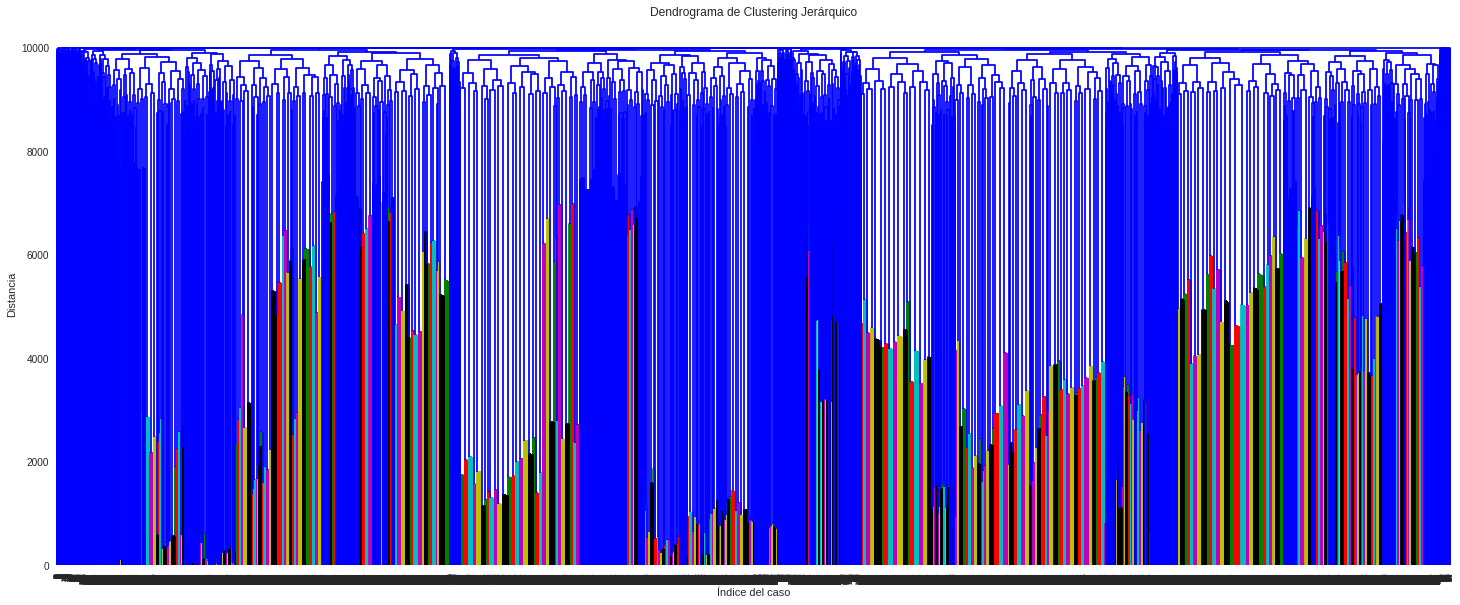

In [21]:
# Creamos la matriz de enlaces que necesita el método dendrogram de scipy
uniones = modeloAglomerativo.children_
# Las distancias y los tamaños, en esta ocasión, los asignamos de manera 
# inocua para no alterar el resultado (no disponemos de la información completa)
distancias = np.arange(uniones.shape[0])
tamanyos = np.arange(2, uniones.shape[0]+2)
mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

plt.figure(figsize=(25, 10))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(mEnlaces)
plt.show()